# <center>**医药行业划分** </center> 
<center>授课老师：王雄</center>

<center>2019023014  黄子珊</center>

2019年疫情爆发，医药行业成为全球的刚需，在这短短的两年时间，医药行业会发生巨大的变动吗？在对大市场进行划分之后，将对细分的医药行业进行行业划分，以探寻其内部结构变化，并对未来做出可能性判断与期冀。

In [7]:
###导入所需相关库
import pandas as pd
import numpy as np
from jqdata import *
from jqdata import finance 
from jqfactor import get_factor_values
###画图
import matplotlib.pyplot as plt
from matplotlib import colors
###时间
import time
import datetime
from datetime import datetime, timedelta
#PCA降维+Kmeans聚类
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy import stats

In [18]:
#忽略warning的输出
import warnings

warnings.filterwarnings('ignore')

## 1. 函数定义
### 定义获取股票列表函数

In [3]:
def Regress(x,y):
    k,d,r,a,b=stats.linregress(x,y)
    return 1-r**2

def GetStockList(startDate=None,reday = None):
#     if(market is None):
#         b = get_all_securities(types=['stock'], date=curdate).display_name
#         stockList = b.index.values.tolist()
#         names = b.values.tolist()
#     else:
    stockList = get_industry_stocks('HY006',date=endDate)
    names = []
    for i in stockList:
        names.append(get_security_info(i).display_name)
        
    flag = i = 0
    length = len(stockList)
    while(flag<length):
        if('S' in names[i]):
            del(stockList[i])
            del(names[i])
            i-=1
        flag += 1
        i += 1  
    temp = get_price(stockList,start_date=startDate,end_date=endDate, 
                  frequency='1d', fields='close', skip_paused=False, fq='pre',count = reday).close.dropna(axis=1,how='any')
    stockList = list(temp.columns.values)
    return stockList


### 定义计算相关系数矩阵函数、聚类函数及可视化函数

In [4]:
def GetCorr(classChange):
    correlation = []
    for price in classChange:
        cont = 0
        corr = 0
        priceArray = pd.DataFrame(np.array(price).T).corr().values
        for i in range(len(price) - 1):
            for j in range(i + 1, len(price)):
                if (priceArray[i][j] != priceArray[i][j]):
                    corr += 0
                    cont += 0
                else:
                    corr += priceArray[i][j]
                    cont += 1
        if (cont != 0):
            correlation.append(corr / cont)

    if (len(correlation) == 0):
        return correlation, 0
    else:
        return correlation, np.mean(correlation)


def Cluster(stockList, clusterNum, minNum, startDate=None, endDate=None, count=None, feq=0):
    price = get_price(stockList, start_date=startDate, end_date=endDate,
                      frequency=str(feq + 1) + 'd', fields='close', skip_paused=False,
                      fq='pre', count=count).close.dropna(axis=1, how='any')
    price = price.values.T

    change = []
    for i in price:
        change.append(np.log(i[1:] / i[:-1]))
    # 获取收盘价
    dataMat = mat(change)
    # 调用sklearn中的PCA，其中主成分有10列
    if (len(change[0]) > 10):
        pca_sk = PCA(n_components=(10))
        # 利用PCA进行降维，数据存在newMat中
        newMat = pca_sk.fit_transform(dataMat)
    else:
        newMat = dataMat
        # 利用KMeans进行聚类，分为n类
    kmeans = KMeans(clusterNum, random_state=0).fit(newMat)
    # labels为分类的标签
    labels = kmeans.labels_
    # score = metrics.silhouette_score(dataMat, labels)
    cluster = [[] for i in range(clusterNum)]
    for i in range(len(labels)):
        cluster[labels[i]].append(stockList[i])
    # 删除长度小于n的类
    flag = 0
    i = 0
    length = len(cluster)
    while (flag < length):
        if (len(cluster[i]) < minNum):
            del (cluster[i])
            i -= 1
        i += 1
        flag += 1
    stockClass = cluster
    return stockClass


def Classify(cluster, stockList, limit, minNum, minClus, startDate=None, endDate=None, count=None, feq=0):
    if (minClus > 0):
        stockClass = Cluster(stockList, minClus, minNum, startDate=startDate, endDate=endDate, count=count, feq=feq)
        minClus = -1
    else:
        stockClass = Cluster(stockList, 2, minNum, startDate=startDate, endDate=endDate, count=count, feq=feq)

    gprice = []
    gchange = []

    for i in stockClass:
        temp = get_price(i, start_date=startDate, end_date=endDate,
                         frequency=str(feq + 1) + 'd', fields='close', skip_paused=False,
                         fq='pre', count=count).close.dropna(axis=1, how='any')
        temp = temp.values.T
        gprice.append(temp)
        change = []
        for j in temp:
            change.append(np.log(j[1:] / j[:-1]))
        gchange.append(change)

    score = []
    reclusterList = []
    score, meanScore = GetCorr(gchange)

    if (len(score) != 1):
        score = score[:len(stockClass)]
        for j in range(len(score)):
            if (score[j] <= limit):
                if (len(stockClass[j]) > minNum):
                    reclusterList.append(stockClass[j])
            else:
                cluster.append(stockClass[j])

    if (len(reclusterList) != 0):
        for i in reclusterList:
            cluster = Classify(cluster, i, limit, minNum, minClus, startDate=startDate, endDate=endDate, count=count,
                               feq=feq)
    return cluster


def DisplayClass(cluster, stockList, limit, minNum, minClus, startDate=None, endDate=None, outDate=None, count=None,
                 feq=0):
    cluster = Classify(cluster, stockList, limit, minNum, minClus, startDate=startDate, endDate=endDate, count=count,
                       feq=feq)

    gprice = []
    gchange = []
    for i in cluster:
        temp = get_price(i, start_date=startDate, end_date=endDate,
                         frequency=str(feq + 1) + 'd', fields='close', skip_paused=False, fq='pre', count=count).close
        date = list(temp.index)
        temp = temp.values.T
        gprice.append(temp)
        tempChange = []
        for j in temp:
            tempChange.append(np.log(j[1:] / j[:-1]))
        gchange.append(tempChange)

    corr, meanCorr = GetCorr(gchange)

    stockPool = []
    stockChange = []
    for i in range(len(cluster)):
        for j in range(len(cluster[i])):
            stockPool.append(cluster[i][j])
            stockChange.append(gchange[i][j])

    delStocks = list(set(stockList) - set(stockPool))
    delName = []
    for i in delStocks:
        delName.append(get_security_info(i).display_name)

    delPrice = get_price(delStocks, start_date=startDate, end_date=endDate,
                         frequency=str(feq + 1) + 'd', fields='close', skip_paused=False, fq='pre',
                         count=count).close.values.T
    delPrice = sum(delPrice, axis=0)
    deltemp = get_price(delStocks, start_date=datetime.strptime(endDate, "%Y-%m-%d") + timedelta(days=1),
                        end_date=outDate,
                        frequency=str(feq + 1) + 'd', fields='close', skip_paused=False, fq='pre',
                        count=count).close.values.T
    deltemp = deltemp.sum(axis=0)
    delPrice = np.hstack((delPrice, np.array(deltemp)))

    priceIndex = []
    for i in gprice:
        priceIndex.append(sum(i, axis=0))
    priceChange = []
    for i in priceIndex:
        priceChange.append(np.log(i[-1] / i[0]))
    rankIndex = list(np.argsort(priceChange))[::-1]
    rankPrice = np.array(priceIndex)[rankIndex]
    rankCluster = np.array(cluster)[rankIndex]
    rankChange = np.array(priceChange)[rankIndex]

    # 画图
    futIndex = []
    for i in rankCluster:
        tempF = get_price(i, start_date=datetime.strptime(endDate, "%Y-%m-%d") + timedelta(days=1), end_date=outDate,
                          frequency=str(feq + 1) + 'd', fields='close', skip_paused=False, fq='pre').close
        tempFdate = list(tempF.index)
        tempF = tempF.values.T
        tempF = tempF.sum(axis=0)
        futIndex.append(tempF)
    edge = len(date)
    date += tempFdate
    allIndex = np.hstack((rankPrice, np.array(futIndex)))

    marketPrice = get_price('000001.XSHG', start_date=date[0], end_date=date[-1],
                            frequency=str(feq + 1) + 'd', fields='close', skip_paused=False, fq='pre').close.values.T

    fig, ax = plt.subplots(figsize=(16, 6))
    for i in range(len(allIndex)):
        ax.plot(date, allIndex[i] / allIndex[i][0], label='NO.%d class %d' % (i + 1, len(rankCluster[i])))
    ax.plot(date, marketPrice / marketPrice[0], linewidth=5, alpha=0.5, label='BentchMarket', color='black')
    ax.axvspan(date[edge - 1], date[-1], color='pink', alpha=0.3)
    ax.set_title('Cluster Result')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)


    stockName = []
    stockCode = []
    stockLabel = []
    industryNum = []
    for i in range(len(rankCluster)):
        industryNum.append(len(rankCluster[i]))
        for j in range(len(rankCluster[i])):
            stockName.append(get_security_info(rankCluster[i][j]).display_name)
            stockCode.append(rankCluster[i][j])
            stockLabel.append(i + 1)

    industryName = ['农林牧渔I', '采掘I', '化工I', '钢铁I', '有色金属I', '电子I', '家用电器I', '食品饮料I', '纺织服装I',
                    '轻工制造I', '医药生物I', '公用事业I', '交通运输I', '房地产I', '商业贸易I', '休闲服务I', '综合I',
                    '建筑材料I', '建筑装饰I', '电气设备I', '国防军工I', '计算机I', '传媒I', '通信I', '银行I', '非银金融I', '汽车I', '机械设备I']

    industryCode = ['801010', '801020', '801030', '801040', '801050', '801080', '801110', '801120', '801130', '801140',
                    '801150', '801160', '801170', '801180', '801200', '801210', '801230', '801710',
                    '801720', '801730', '801740', '801750', '801760', '801770', '801780', '801790', '801880', '801890']

    swClass = []
    for i in industryCode:
        swClass.append(get_industry_stocks(i, date='2020-12-31'))

    originInd = []
    for i in range(len(rankCluster)):
        for j in range(len(rankCluster[i])):
            flag = 0
            for k in range(len(swClass)):
                if (rankCluster[i][j] in swClass[k]):
                    flag = 1
                    originInd.append(industryName[k])
                    break
            if (flag == 0):
                originInd.append('其他')

    stocksize = pd.DataFrame({'CODE': stockCode,
                              'NAME': stockName,
                              'LABEL': stockLabel,
                              '所属申万一级行业': originInd
                              })

    oversize = pd.DataFrame({
        '行业个数': [len(cluster)],
        '平均行业内相关系数': [meanCorr],
        '总成分股数目': [len(stockPool)],
        '已剔除': [len(delStocks)]
    })

    industrysize = pd.DataFrame({
        '成分股个数': industryNum,
        '行业内相关系数': corr,
        '样本内收益': rankChange
    })

    delstocksize = pd.DataFrame({
        '剔除的股票代码': delStocks,
        '剔除的股票名称': delName
    })

    # print(oversize)
    # print(industrysize)
    # print(delstocksize)
    # print(stocksize)

    return allIndex, rankCluster, stocksize, oversize, industrysize, delstocksize

In [1]:
def get_index_univ(index_id, date, n=90):
    """
    获取指数某天的成分股
    params:
        index_id：指数代码
        date：日期
        n：次新股天数
    return：
        univ：指数某天的成分股
    """
    stockList = get_industry_stocks(index_id, date)

    # 剔除科创板股票
    stockList = [stk for stk in stockList if stk[:3] !='688']

    # 剔除st股
    st_data = get_extras('is_st', stockList, count = 1, end_date=date)
    stockList = [stock for stock in stockList if not st_data[stock][0]]

    # 剔除n天内的次新股
    univ = []
    dt = datetime.strptime(date, "%Y-%m-%d")
    for stock in stockList:
        start_date = get_security_info(stock).start_date
        if start_date < (dt-timedelta(days = n)).date():
            univ.append(stock)
    return univ

In [2]:
def get_period_date(peroid, start_date, end_date):
    """
    获取指定周期的日期列表
    param:
        peroid: 周是'W',月'M',季度线'Q',五分钟'5min',12天'12D'
        start_date: 开始时间
        end_date: 结束时间
    return:
        list，开始至结束时间的指定周期的日期列表
    """
    stock_data = get_price('000001.XSHE',start_date,end_date,'daily',fields=['close'])
    stock_data['date']=stock_data.index
    period_stock_data=stock_data.resample(peroid).last()
    
    date=period_stock_data.index
    pydate_array = date.to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
    date_only_series = pd.Series(date_only_array)

    date_list = date_only_series.values.tolist()
    TradeDate = []
    for i in date_list:
        temp = list(get_trade_days(end_date=i, count=1))[0]
        TradeDate.append(str(temp))
    return TradeDate

In [3]:
def get_dynamic_univ(date_list, index_id):
    """
    获取指数的动态成分股
    params：
        date_list：交易日列表
        index_id：指数代码
    """
    univ_list = []
    for date in date_list:
        temp_univ = get_index_univ(index_id, date)
        temp_df = pd.DataFrame(temp_univ, index=[date]*len(temp_univ))
        univ_list.append(temp_df)
    univ_df = pd.concat(univ_list)
    univ_df.index.name = 'date'
    univ_df.columns = ['code']
    return univ_df

### 医药行业上市公司的数量变化 

医药行业上市公司的数量，从20090101的114支逐步增多，截止20200301，医药行业共计 293 家上市公司，

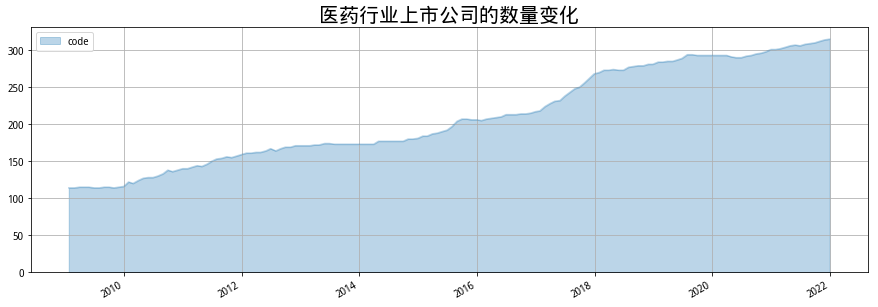

In [8]:
start_date = '2009-01-01'
end_date = str(datetime.now().date())

trade_month_list = get_period_date('M', start_date, end_date)
# print(trade_month_list)
dy_medicine_df = get_dynamic_univ(trade_month_list, '801150')
dy_medicine_count = dy_medicine_df.groupby(level='date').count()


fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

dy_medicine_count.index = [datetime.strptime(dt, "%Y-%m-%d") for dt in dy_medicine_count.index]
dy_medicine_count[['code']].plot(kind='area', alpha=0.3, ax=ax)
ax.set_title('医药行业上市公司的数量变化', fontsize = 20)
ax.grid(True)

### 聚类结果

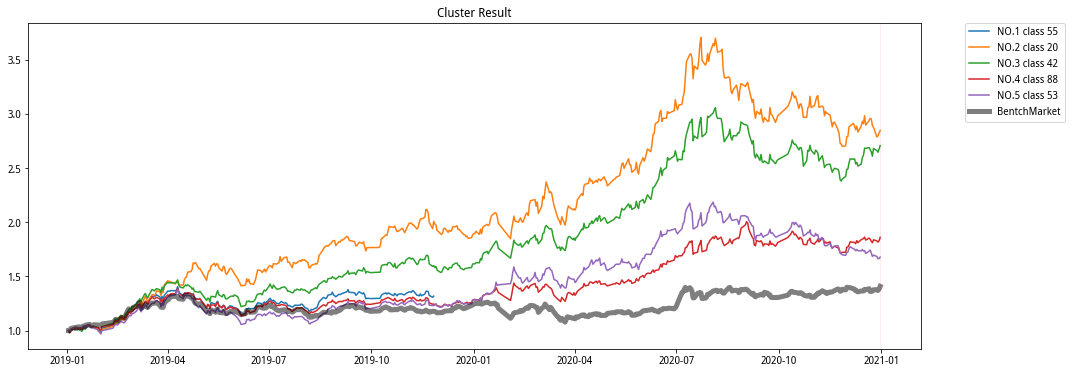

In [13]:
cluster=[]
limit=0.3
minNum=20
minClus=8
startDate = '2019-01-01'
endDate = '2020-12-31'
outDate = None
count = None 
feq = 0
stockList = get_industry_stocks('HY006',date=startDate)
allIndex,stockClass1,stocksize,oversize,industrysize,delstocksize=DisplayClass(cluster,stockList,limit,
                        minNum,minClus,startDate,endDate,outDate,count,feq)

### 细分行业数量变化

In [11]:
idu = pd.read_csv('medicine_ind.csv',encoding = "gb2312")
cnlabels=[u'医疗器械',u'化学制药',u'医疗商业',u'中药-生物制品混合',u'医疗服务']
idu['cnlabels']=cnlabels
idu

,LABEL,NUMBER,CORR,SAM_PRO,STOCKS,cnlabels
0,0,55,0.297483,0.780672,"['000004.XSHE', '000403.XSHE', '000710.XSHE', ...",医疗器械
1,1,20,0.329686,1.045815,"['000590.XSHE', '000638.XSHE', '300015.XSHE', ...",化学制药
2,2,42,0.352319,0.995782,"['000513.XSHE', '000661.XSHE', '000739.XSHE', ...",医疗商业
3,3,88,0.313845,0.621267,"['000028.XSHE', '000150.XSHE', '000153.XSHE', ...",中药-生物制品混合
4,4,53,0.307676,0.518067,"['000078.XSHE', '000518.XSHE', '000597.XSHE', ...",医疗服务


In [6]:
whichpart=[u'医疗器械',u'化学制药',u'医疗商业',u'中药-生物制品混合',u'医疗服务']

In [8]:
df_final = pd.DataFrame()
for k in range(len(whichpart)):
    num = []
    num1 = []

    for i in range(11):
        dt = datetime(2009 + i, 1, 1)
        #     for i in range(len(idu)):
        a = idu.STOCKS[k].strip('[]').replace('\'', '').replace(' ', '').split(",")
        df1 = get_fundamentals(query(
            valuation
        ).filter(
            # 这里不能使用 in 操作, 要使用in_()函数
            valuation.code.in_(a)
        ), date=dt)
        #     print(len(df1))
        num.append(len(df1))
        num1.append(dt)
    df_final['date'] = num1
    df_final[whichpart[k]] = num
df_final

,date,医疗器械,化学制药,医疗商业,中药-生物制品混合,医疗服务
0,2009-01-01,16,2,10,51,29
1,2010-01-01,19,3,11,52,31
2,2011-01-01,25,4,11,61,38
3,2012-01-01,29,12,11,63,44
4,2013-01-01,33,12,16,63,45
5,2014-01-01,33,12,16,63,45
6,2015-01-01,35,14,17,68,46
7,2016-01-01,39,16,21,76,47
8,2017-01-01,42,20,24,79,48
9,2018-01-01,54,20,39,88,52


In [11]:
del df_final['date']

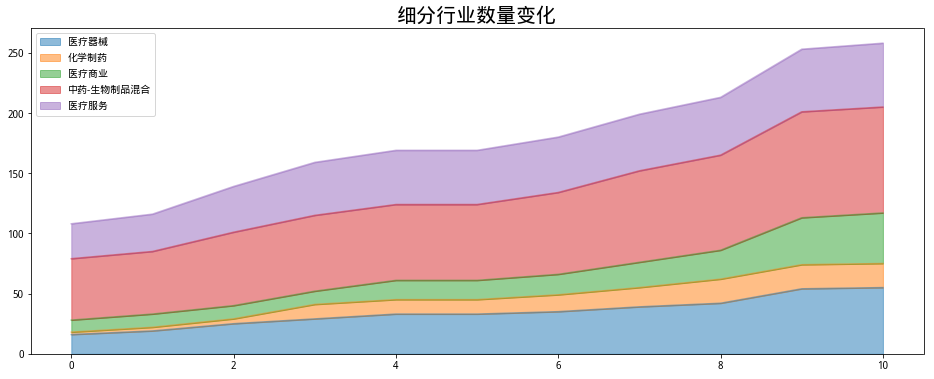

In [12]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)

df_final.plot(kind='area', alpha=0.5, ax=ax)
ax.set_title('细分行业数量变化', fontsize = 20)
plt.show()

In [9]:
# stocksize.to_csv('medicine.csv')
stocksize = pd.read_csv('medicine.csv')

In [12]:
start='2019-01-01'    
end='2020-12-31'

class_avg_list=[]#classk_avg=class_avg_list[k]
for i in range(len(idu)):
    class_avg_list.append([])

In [93]:
idu['STOCKS'][0]

"['000004.XSHE', '000403.XSHE', '000710.XSHE', '000915.XSHE', '000963.XSHE', '002001.XSHE', '002019.XSHE', '002262.XSHE', '002294.XSHE', '002317.XSHE', '002332.XSHE', '002399.XSHE', '002562.XSHE', '002626.XSHE', '002653.XSHE', '002680.XSHE', '002864.XSHE', '002873.XSHE', '002907.XSHE', '002923.XSHE', '300006.XSHE', '300110.XSHE', '300142.XSHE', '300147.XSHE', '300206.XSHE', '300239.XSHE', '300289.XSHE', '300294.XSHE', '300381.XSHE', '300404.XSHE', '300451.XSHE', '300485.XSHE', '300562.XSHE', '300583.XSHE', '300630.XSHE', '300633.XSHE', '300636.XSHE', '300677.XSHE', '300705.XSHE', '300725.XSHE', '600161.XSHG', '600196.XSHG', '600211.XSHG', '600276.XSHG', '600351.XSHG', '600624.XSHG', '600851.XSHG', '600976.XSHG', '601607.XSHG', '603222.XSHG', '603368.XSHG', '603520.XSHG', '603538.XSHG', '603976.XSHG', '603987.XSHG']"

In [19]:
for k in range(len(idu)):  # 类别
    data = get_price(idu.STOCKS[k].strip('[]').replace('\'','').replace(' ','').split(","), start_date=start,
                     end_date=end, frequency='daily', fields=['open', 'close'], skip_paused=False, fq='pre')
    data0 = data.close.values / data.close.values[0]
    for j in range(len(data0)):  # 时间
        flag = 0
        for i in range(len(data0[0])):  # 编号循环
            flag = flag + data0[j][i]
        class_avg_list[k].append(flag / len(data0[k]))

idu['avglist'] = class_avg_list
last_avg_list = []
for i in range(len(class_avg_list)):
    last_avg_list.append(class_avg_list[i][-1])

idu['lastavg'] = last_avg_list
idu_aft = idu.sort_values(by=['lastavg'], ascending=False)

idu_aft.index = arange(0, len(idu_aft))

In [20]:

cnlabels=[u'医疗器械',u'化学制药',u'医疗商业',u'中药-生物制品混合',u'医疗服务']
idu_aft['cnlabels']=cnlabels
idu_aft['lastavg'][4]=1.45238
idu_aft

,LABEL,NUMBER,CORR,SAM_PRO,STOCKS,cnlabels,avglist,lastavg
0,2,42,0.352319,0.995782,"['000513.XSHE', '000661.XSHE', '000739.XSHE', ...",医疗器械,"[1.0, 0.9875665825457444, 1.0105166795034517, ...",2.296459
1,1,20,0.329686,1.045815,"['000590.XSHE', '000638.XSHE', '300015.XSHE', ...",化学制药,"[1.0, 0.9901258741050964, 1.0173887767549972, ...",2.227950
2,4,53,0.307676,0.518067,"['000078.XSHE', '000518.XSHE', '000597.XSHE', ...",医疗商业,"[1.0, 0.9942250212735875, 1.015560996354763, 1...",1.547049
3,3,88,0.313845,0.621267,"['000028.XSHE', '000150.XSHE', '000153.XSHE', ...",中药-生物制品混合,"[1.0, 0.9882936776608229, 1.0115453891087127, ...",1.453678
4,0,55,0.297483,0.780672,"['000004.XSHE', '000403.XSHE', '000710.XSHE', ...",医疗服务,"[1.0, 0.9844628418811585, 1.0078717956784833, ...",1.452380


### 各类别中上市公司数量变化数

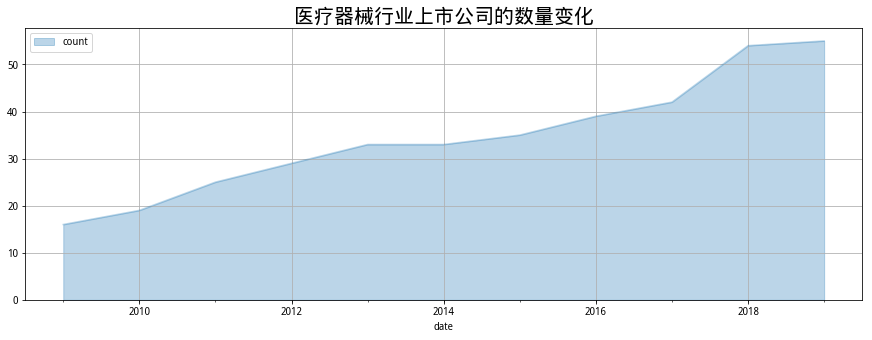

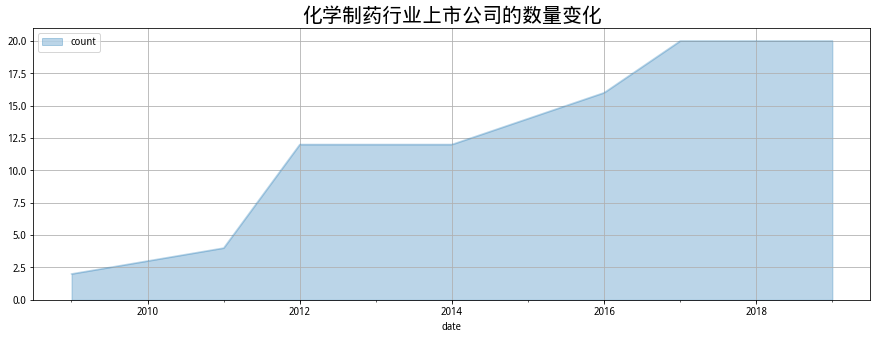

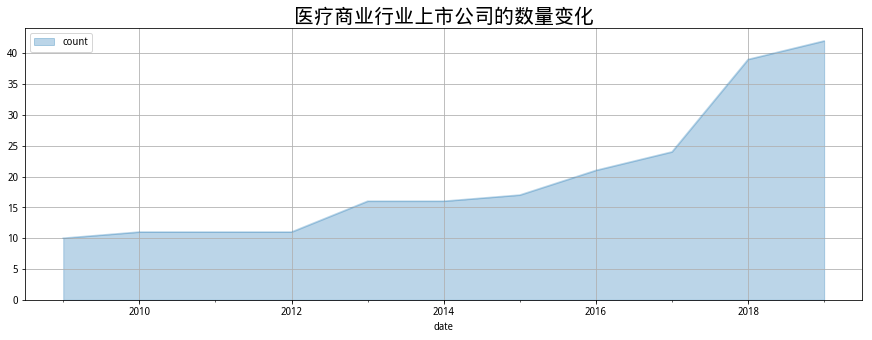

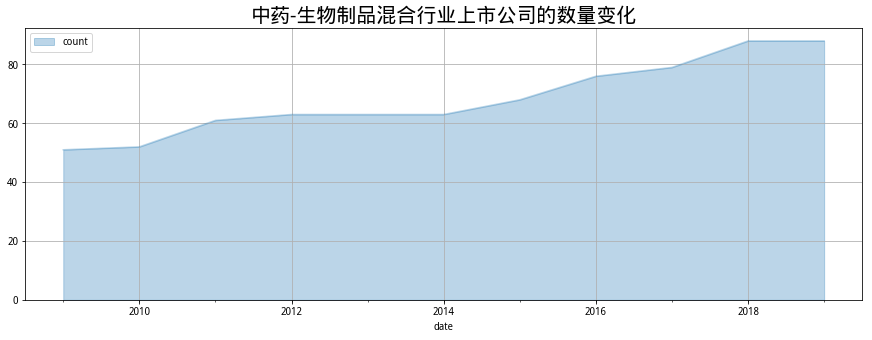

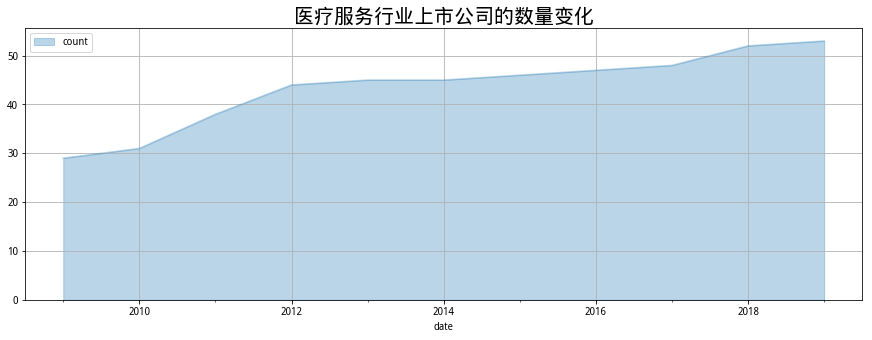

In [15]:
for k in range(len(whichpart)):
    num = []
    num1 = []
    df2 = pd.DataFrame()
    for i in range(11):
        dt = datetime(2009 + i, 1, 1)
        #     for i in range(len(idu)):
        a = idu.STOCKS[k].strip('[]').replace('\'', '').replace(' ', '').split(",")
        df1 = get_fundamentals(query(
            valuation
        ).filter(
            # 这里不能使用 in 操作, 要使用in_()函数
            valuation.code.in_(a)
        ), date=dt)
        #     print(len(df1))
        num.append(len(df1))
        num1.append(dt)
    df2['date'] = num1
    df2['count'] = num
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(111)

    df2.index = df2['date']
    df2[['count']].plot(kind='area', alpha=0.3, ax=ax)
    ax.set_title(whichpart[k]+'行业上市公司的数量变化', fontsize=20)
    ax.grid(True)

### 各类别平均收益率

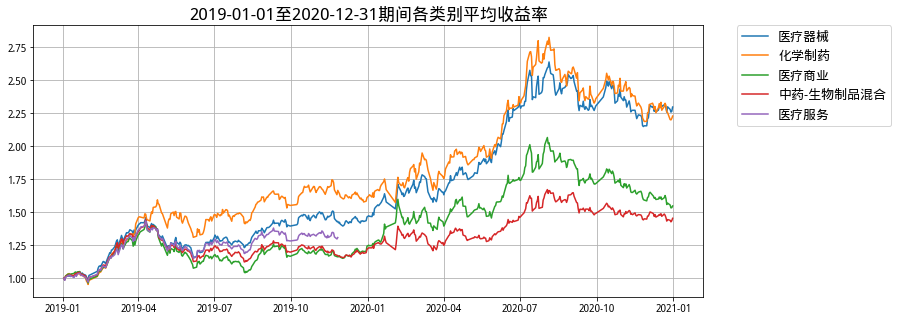

In [68]:
#走势图
plt.figure(figsize=(12,5))
plt.title('%s至%s期间各类别平均收益率'%(start,end),fontsize=17) 
for i in range(len(idu_aft)):
    plot(data.close.index,idu_aft.avglist.values[i],label=str(idu_aft['cnlabels'].values[i]))    
    plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=13) 

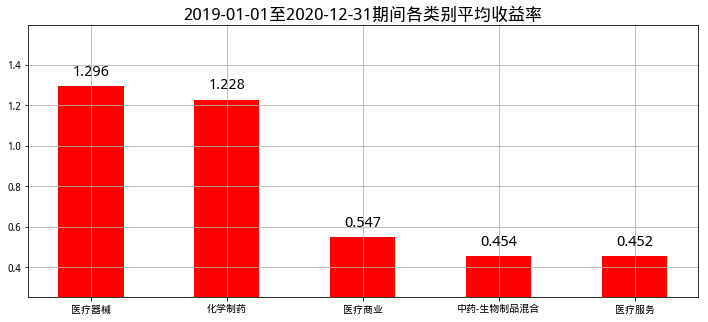

In [69]:
#柱状图

colorbox=['r','g']
colorchoice=[]
colorstr=''
c=""
yrate=[x-1 for x in idu_aft.lastavg.values]
idu=np.linspace(0.5,5.5,5)
width=0.6
for i in range(len(yrate)):
    if yrate[i]>=0 :
        colorchoice.append('r')
    else :
        colorchoice.append('g')
for e in colorchoice:        
    colorstr+=e+'' 

plt.figure(figsize=(12,5))
plt.title('%s至%s期间各类别平均收益率'%(start,end),fontsize=17) 

plt.bar(idu,yrate,width,color=colorstr,
        tick_label=idu_aft['cnlabels'].values)    
plt.ylim(min(yrate)-0.2,max(yrate)+0.3)
for a,b in zip(idu-width/2,yrate):
    if b>=0 :
        sign=1
        position='bottom'
    else :
        sign=-1    
        position='top'
    plt.text(a+width/2, b+(sign)*((max(yrate)+0.2-min(yrate)-0.1)/25),'%.3f'%b,ha='center',va=position,fontsize=15)
plt.grid()

### 各类别平均超额收益率

In [73]:
start = '2019-01-01'
end = '2020-12-31'

exceed_rate = []

# 标准
data_standard = get_price('000300.XSHG', start_date=start, end_date=end,
                          frequency='daily', fields=['open', 'close'], skip_paused=False, fq='pre')
data_standard.index = pd.to_datetime(data_standard.index, format='%Y-%m-%d')  # 将tradeDate从字符串格式转化为datetime格式
data_standard['rate_by_day'] = data_standard.close / data_standard.close[0]
yrate_standard = (data_standard.close[-1] - data_standard.open[0]) / data_standard.open[0]

class_avg_list = []  # classk_avg=class_avg_list[k]
for i in range(len(idu)):
    class_avg_list.append([])
for k in range(len(idu)):  # 类别
    data = get_price(idu.STOCKS[k].strip('[]').replace('\'','').replace(' ','').split(","), start_date=start,
                     end_date=end, frequency='daily', fields=['open', 'close'], skip_paused=False, fq='pre')
    data0 = data.close.values / data.close.values[0]
    for j in range(len(data0)):  # 时间
        flag = 0
        for i in range(len(data0[0])):  # 编号循环
            flag = flag + data0[j][i]
        class_avg_list[k].append(flag / len(data0[k]))
# for k in range(len(idu)):  # 类别
#     data = get_price(idu.STOCKS[k].strip('[]').replace('\'', '').replace(' ', '').split(","), start_date=start,
#                      end_date=end, frequency='daily', fields=['open', 'close'], skip_paused=False, fq='pre')
#     data0 = data.close.values / data.close.values[0]
#     for j in range(len(data0)):  # 时间
#         flag = 0
#         for i in range(len(data0[0])):  # 编号循环
#             flag = flag + data0[j][i]
#         class_avg_list[k].append(flag / len(data0[k]))

idu['avglist'] = class_avg_list
cnlabels = [u'医疗器械',u'化学制药',u'医疗商业',u'中药-生物制品混合',u'医疗服务']
idu['cnlabels'] = cnlabels
last_avg_list = []
for i in range(len(class_avg_list)):
    last_avg_list.append(class_avg_list[i][-1])

idu['lastavg'] = last_avg_list
idu_aft = idu.sort_values(by=['lastavg'], ascending=False)

idu_aft.index = arange(0, len(idu_aft))

for i in range(0, len(idu_aft.avglist), 1):
    exceed_rate.append(idu_aft.avglist[i] - data_standard['rate_by_day'].values)
#    yrate_aftsort.append(exceed_rate[i])

#    for i in range(0,len(yrate),1):
#        showchart.exceed[i]=exceed_rate[i]

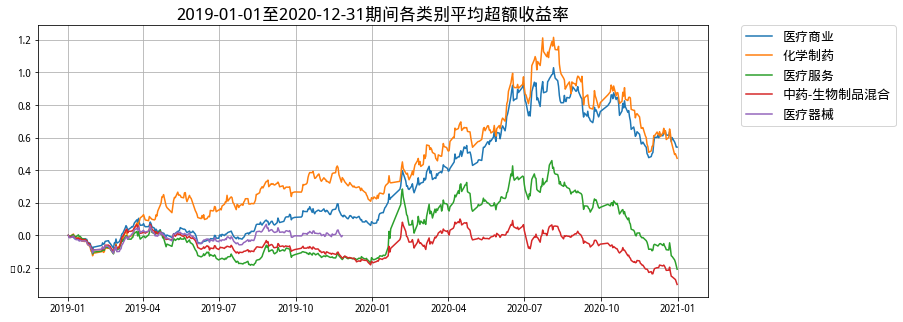

In [74]:
# 走势图
plt.figure(figsize=(12, 5))
plt.title('%s至%s期间各类别平均超额收益率' % (start, end), fontsize=17)
for i in range(len(idu_aft)):
    plot(data.close.index, exceed_rate[i], label=str(idu_aft['cnlabels'].values[i]))
    plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=13)

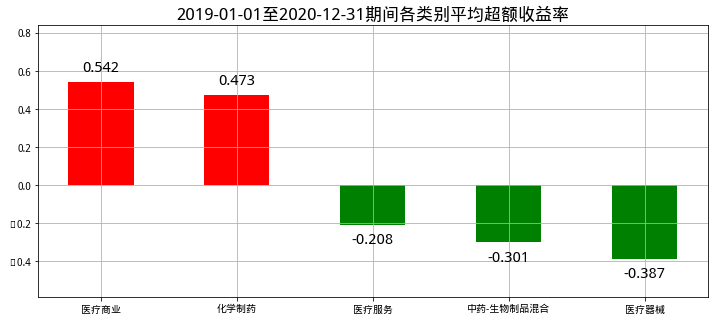

In [75]:
# 柱状图

colorbox = ['r', 'g']
colorchoice = []
colorstr = ''
c = ""

xx = []
for i in range(len(exceed_rate)):
    xx.append(exceed_rate[i][-1])
yrate = [x for x in xx]
yrate[4]=-0.38726172
ind = np.linspace(0.5, 5.5, 5)
width = 0.6
for i in range(len(yrate)):
    if yrate[i] >= 0:
        colorchoice.append('r')
    else:
        colorchoice.append('g')
for e in colorchoice:
    colorstr += e + ''

plt.figure(figsize=(12, 5))
plt.title('%s至%s期间各类别平均超额收益率' % (start, end), fontsize=17)

plt.bar(ind, yrate, width, color=colorstr,
        tick_label=idu_aft['cnlabels'].values)
plt.ylim(min(yrate) - 0.2, max(yrate) + 0.3)

for a, b in zip(ind - width / 2, yrate):
    if b >= 0:
        sign = 1
        position = 'bottom'
    else:
        sign = -1
        position = 'top'
    plt.text(a + width / 2, b + (sign) * ((max(yrate) + 0.2 - min(yrate) - 0.1) / 25), '%.3f' % b, ha='center',
             va=position, fontsize=15)
plt.grid()

### 相关财务数据可视化(市值、市盈率与收益分布)

In [80]:
def draw_distribution(whichpart,stockstart,stockend,factortime):
    stocklist=idu[idu.cnlabels==whichpart].STOCKS.values[0].strip('[]').replace('\'','').replace(' ','').split(",")
    stockname = stocklist
#     stockname = stocksize['CODE']
    stockprice=[]
    return_rate=[]
    stock_cnname=[]
    for i in range(0,len(stockname),1):
#         if(whichpart=="医疗器械" and i==0):
#             continue
        stockprice.append(get_price(stockname[i],start_date=stockstart,end_date=stockend
                                ,frequency='daily',fields=['open','close'],skip_paused=False, fq='pre'))
        return_rate.append((stockprice[i].close[-1]-stockprice[i].open[0])/stockprice[i].open[0])

    #获取多只股票在某一日期的PE和市值cap
    df1 = get_fundamentals(query(valuation.code,valuation.pe_ratio,valuation.market_cap).filter(valuation.code.in_(stockname)), date=factortime)
    df1.index=df1['code']
    del df1['code']
    
    df2 = get_fundamentals(query(indicator.code,indicator.roe).filter(indicator.code.in_(stockname)), date=factortime)
    df2.index=df2['code']
    del df2['code']
    
        #获取股票名字
    for i in range(0,len(stockname),1):
        stock_cnname.append(get_security_info(stockname[i]).display_name)
    #print stock_cnname


    result=df1.join(df2)
#     print(len(result))


    if(whichpart=="医疗器械"):
        del return_rate[0]
        del stock_cnname[0]
#     print(len(return_rate))
#     print(len(stock_cnname))
    result['return_rate']=return_rate
    result['cnname']=stock_cnname
    indexcnname=whichpart#str(get_security_info(stocklist).display_name)
    
    result_aftsort=result.sort_values(by=['return_rate'],ascending=False).dropna(axis=0,how='any')
    blist=result_aftsort.head(3)
    wlist=result_aftsort.tail(3)
    best5_index=blist.index.values
    worst5_index=wlist.index.values
    
    x=[best5_index,worst5_index]
    y=[blist.cnname,wlist.cnname] 
    title=['最好','最差']
    
    for j in (0,1) :  
        plt.figure(figsize=(13,6))
        plt.title('%s至%s%s板块%s3支走势对比'%(stockstart,stockend,indexcnname,title[j]),fontsize=20)    
        plt.xlabel('时间',fontsize=18)
        closeprice=[]
        tradedate=[]
        closerate=[] 
        for i in range(0,len(x[j]),1):
            closeprice.append(get_price(x[j][i], start_date=stockstart, end_date=stockend, frequency='daily', fields=['close'],
                                skip_paused=False, fq='pre').close.values)
            closerate.append(closeprice[i]/closeprice[i][0])
            tradedate.append(get_price(x[j][i], start_date=stockstart, end_date=stockend, frequency='daily', fields=['close'],
                                skip_paused=False, fq='pre').index.values)
            plt.plot(tradedate[i],closerate[i],linewidth=2,label=str(y[j][i]))
            plt.legend(loc='best',fontsize=11)
            plt.grid()
    
    #市值市盈率散点图
    #过滤极端值（要先整合到dataframe里面！！）还要增加一列return rate
    result=result.sort_values(by=['market_cap'],ascending=False)
    result['cap_rank']=np.arange(1,len(result)+1,1)
    result=result.sort_values(by=['pe_ratio'],ascending=False)
    result['pe_rank']=np.arange(1,len(result)+1,1)
    result=result.sort_values(by=['roe'],ascending=False)
    result['roe_rank']=np.arange(1,len(result)+1,1)
    
    #result=result[result.pe_ratio<=3000].dropna()
    pe_rank=result.pe_rank.values
    cap_rank=result.cap_rank.values
    roe_rank=result.roe_rank.values
    return_rate=result.return_rate
    
    pe=result.pe_ratio.values
    cap=result.market_cap.values
    roe=result.roe.values 
   
    
    #cm = plt.cm.get_cmap('RdYlGn_r')  
    cm2= colors.ListedColormap(['#32CD32','#F08080','#FF4500','#8B0000'],N=4)
    plt.figure(figsize=(12,12))
    plt.title('%s板块 PE、ROE、市值、收益率'%(indexcnname),fontsize=20)
    plt.xlabel('PE排名',fontsize=18)
    plt.ylabel('ROE排名',fontsize=18)
    plt.scatter(pe_rank,roe_rank,s=(cap/50),c=return_rate,alpha=0.8,cmap=cm2)
    for a,b,c in zip(pe_rank,roe_rank,result.cnname):
            plt.text(a,b-0.5,'%s'%str(c),ha='center',va='top',fontsize=10)
    plt.colorbar() 

In [14]:
stockstart='2019-01-01'#股票行情开始时间
stockend='2020-12-31'#股票行情结束时间
factortime='2020-12-31'#财务数据取值时间
whichpart=[u'医疗器械',u'化学制药',u'医疗商业',u'中药-生物制品混合',u'医疗服务']

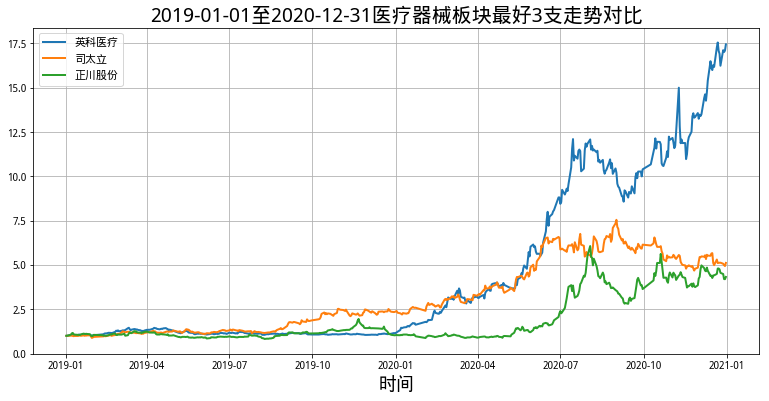

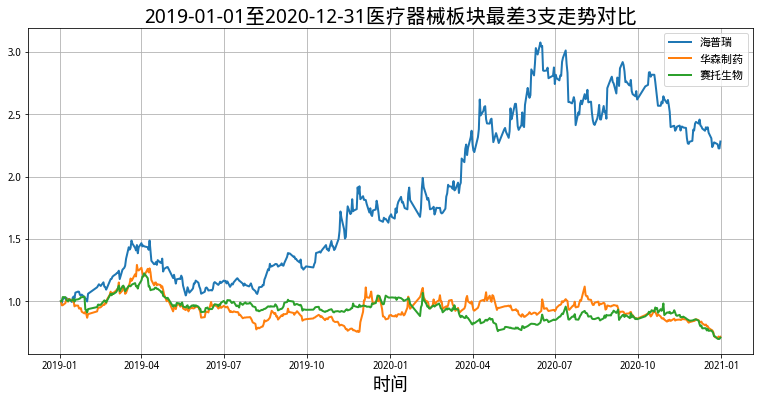

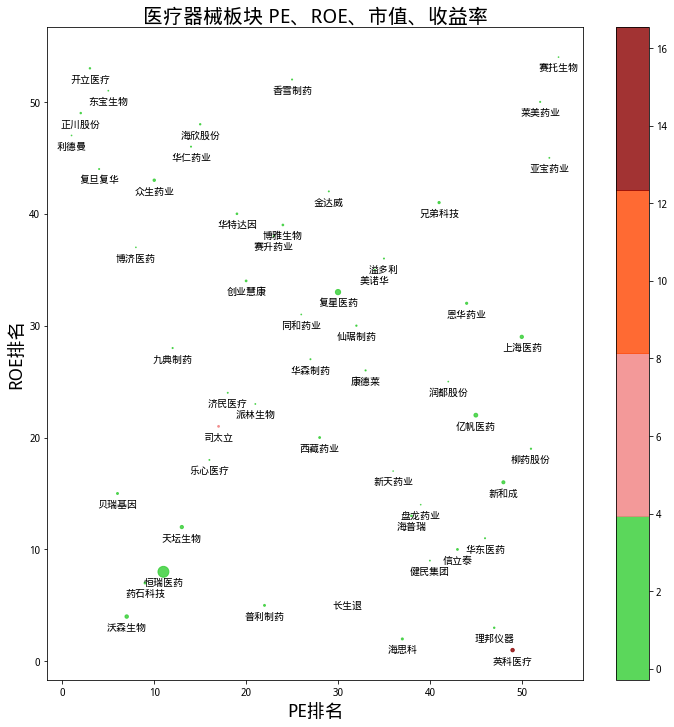

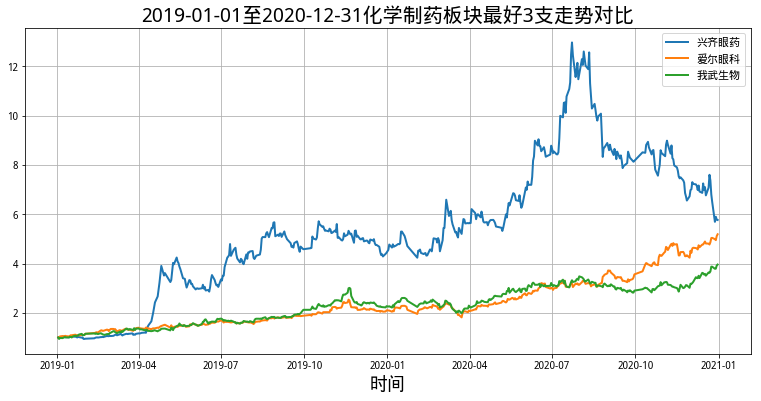

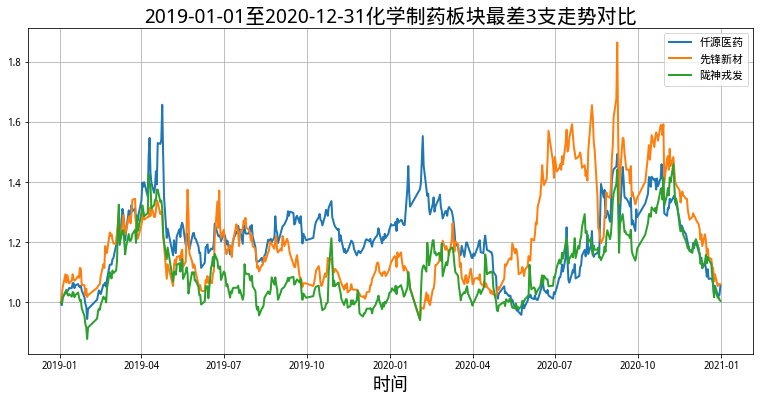

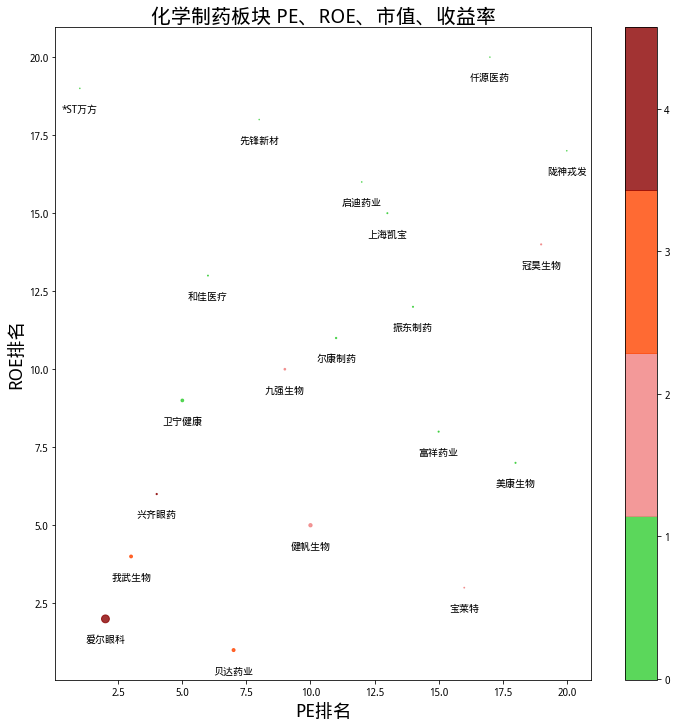

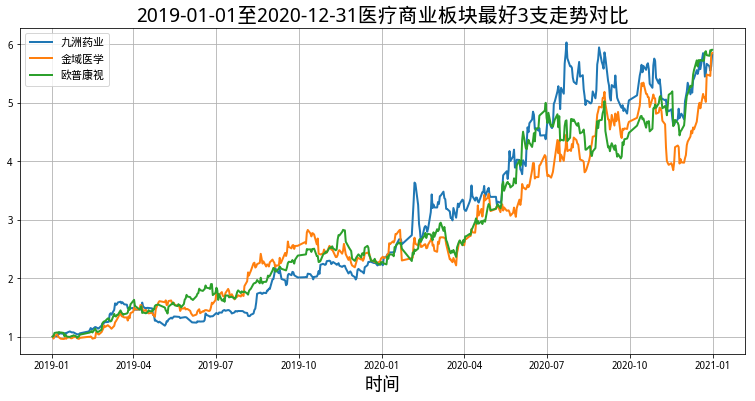

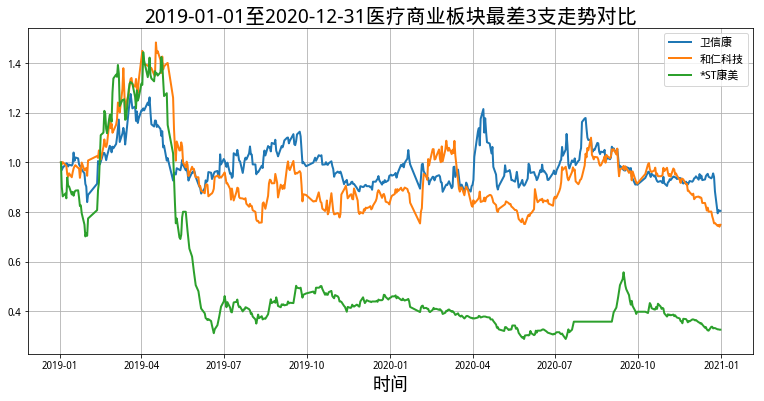

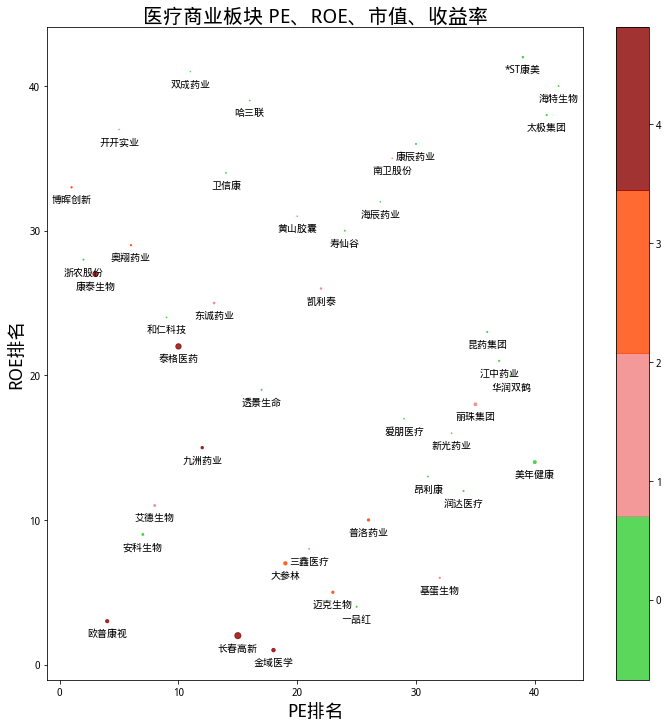

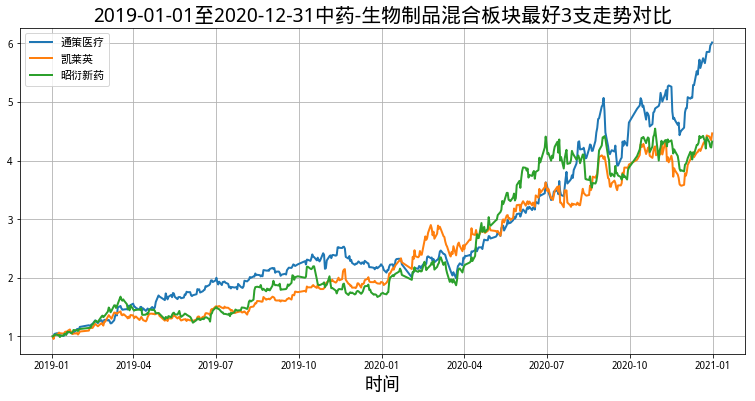

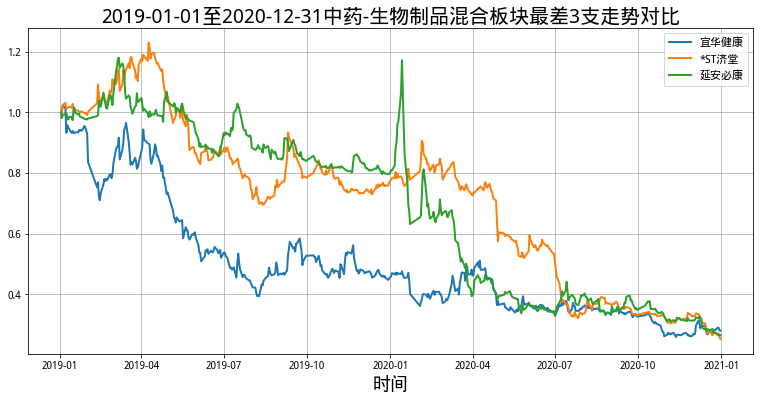

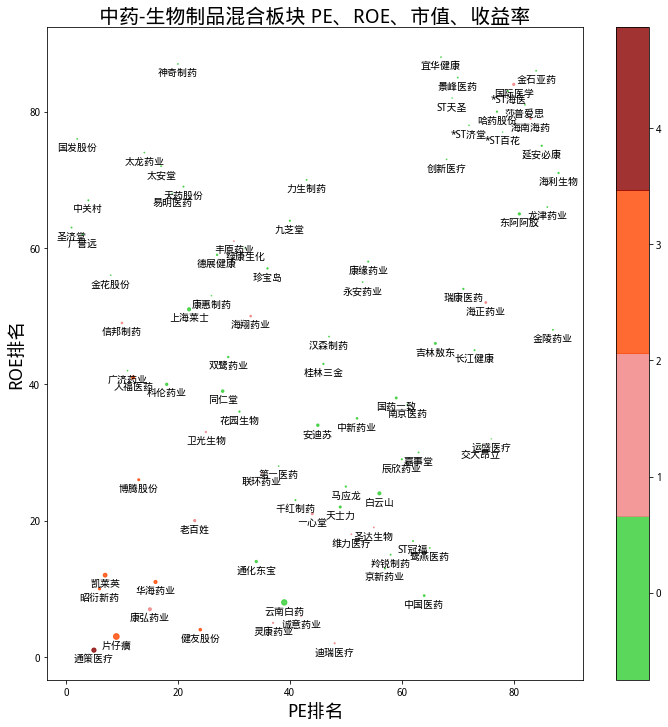

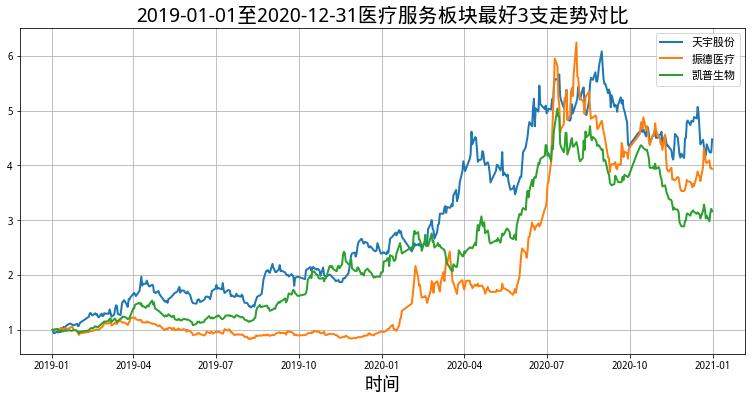

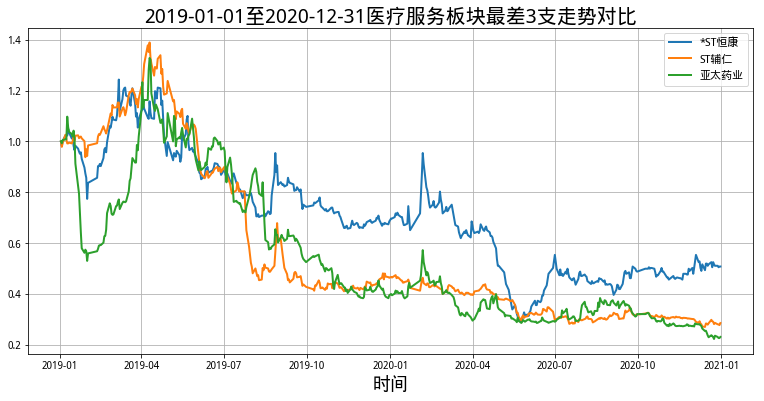

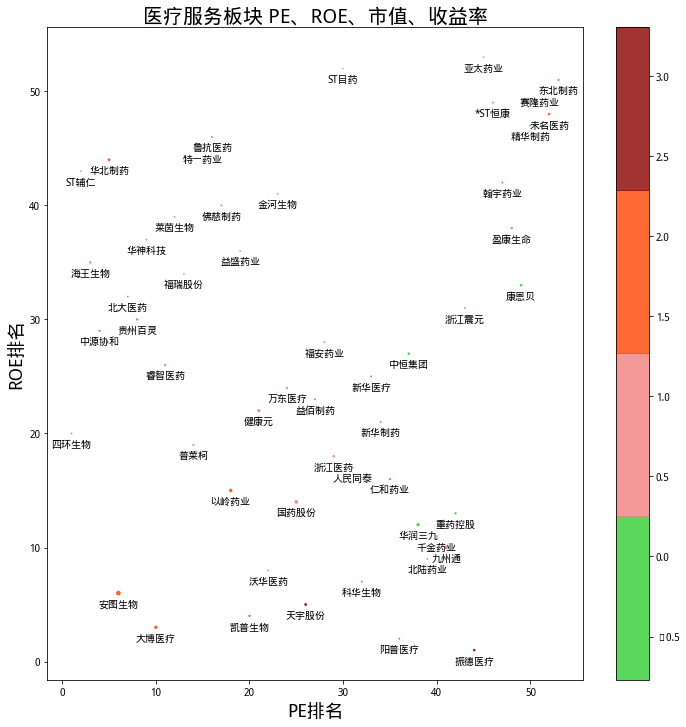

In [81]:
for i in whichpart:
    draw_distribution(i,stockstart,stockend,factortime)

### 细分行业差别
下表以比较了各细分行业在营业利润、营业收入、销售毛利率等方面的差别。

细分行业的差别(2020 年年报，取细分行业平均值)

In [6]:
type_list1 = []
type_list2 = []
type_list3 = []
type_list4 = []
for i in range(len(idu)):
    a = idu.STOCKS[i].strip('[]').replace('\'','').replace(' ','').split(",")
    df = get_fundamentals(query(
     valuation, income,indicator
      ).filter(
          # 这里不能使用 in 操作, 要使用in_()函数
          valuation.code.in_(a)
      ), date='2020-12-31')
    b = sum(df['expense_to_total_revenue'])/len(df['expense_to_total_revenue'])
    c = sum(df['operation_profit_to_total_revenue'])/len(df['operation_profit_to_total_revenue'])
    d = sum(df['net_profit_to_total_revenue'])/len(df['net_profit_to_total_revenue'])
    e = sum(df['gross_profit_margin'])/len(df['gross_profit_margin'])
    type_list1.append(b)
    type_list2.append(c)
    type_list3.append(d)
    type_list4.append(e)
ty = pd.DataFrame(type_list1)
ty.index = whichpart
ty=ty.rename(columns={0:'营业总成本/营业总收入(%)'}) 
ty['营业利润/营业总收入(%)'] = type_list2
ty['净利润/营业总收入(%)'] = type_list3
ty['销售毛利率'] = type_list4
ty

,营业总成本/营业总收入(%),营业利润/营业总收入(%),净利润/营业总收入(%),销售毛利率
医疗器械,83.803519,18.790741,15.953704,52.744259
化学制药,84.615500,21.224000,17.905500,58.198500
医疗商业,84.287619,18.041190,14.864762,56.452143
中药-生物制品混合,87.919545,15.170227,8.491932,46.732955
医疗服务,92.778113,10.609057,8.471132,49.928491


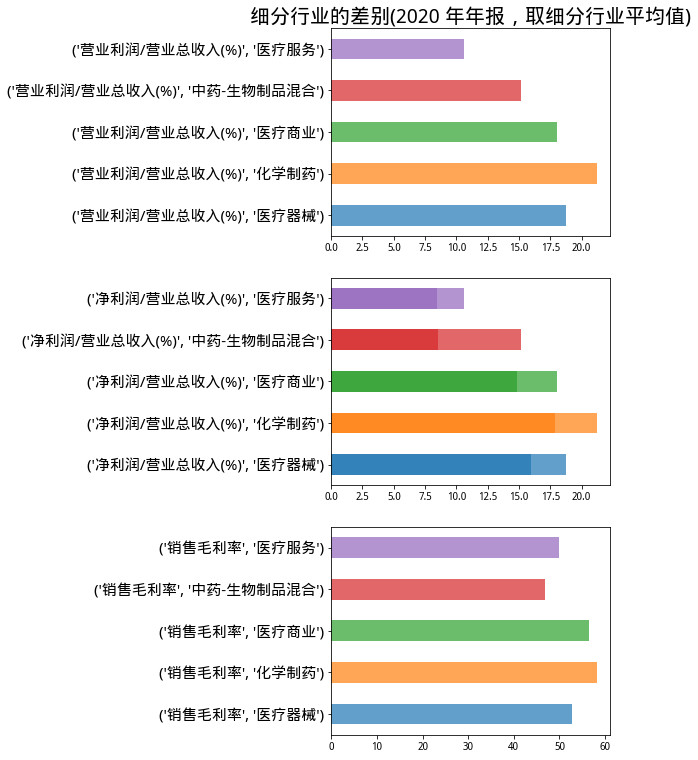

In [7]:
fig = plt.figure(figsize=(5, 13))
ax = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

temp_df = ty[['营业利润/营业总收入(%)']]
temp_df.T.stack().plot(kind='barh', alpha=0.7, ax=ax)
ax.set_title('细分行业的差别(2020 年年报，取细分行业平均值)', fontsize = 20)
ax.set_yticklabels(temp_df.T.stack().index, fontsize=15)

temp_df = ty[['营业利润/营业总收入(%)']]
temp_df.T.stack().plot(kind='barh', alpha=0.7, ax=ax2)
ax2.set_yticklabels(temp_df.T.stack().index, fontsize=15)

temp_df = ty[['净利润/营业总收入(%)']]
temp_df.T.stack().plot(kind='barh', alpha=0.7, ax=ax2)
ax2.set_yticklabels(temp_df.T.stack().index, fontsize=15)


temp_df = ty[['销售毛利率']]
temp_df.T.stack().plot(kind='barh', alpha=0.7, ax=ax3)
ax3.set_yticklabels(temp_df.T.stack().index, fontsize=15)
plt.show()